# Compute BFE with a 32 MEMS square antenna and a white noise source 
® *Copyright Bimea 2024-2025*

Load absolute positiones of MEMS and transform them into positions relative to the center of the antenna

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from megamicros.core.mu import MU_MEMS_SENSIBILITY
from megamicros.acoustics.bmf import BeamformerFDAS
from megamicros.geometry import horizontalPlan

## Compute MEMS positions

This step is not mandatory. If you have already the relative positions you do not need it. 
Otherwise you need to transform absolute positions in relative position.

In [ ]:
with open("mems_position_square_absolute.json", "r") as f:
    mems_position_square_absolute = json.load(f)

print("mems_position_square_absolute.shape: ", np.array(mems_position_square_absolute).shape)
print("mems_position_square_absolute: ", mems_position_square_absolute)

antenna_center_position = [25.0, 27.0, 0.0]
mems_position_square_relative = np.array(mems_position_square_absolute) - np.array(antenna_center_position)
print("mems_position_square_relative.shape: ", mems_position_square_relative.shape)

# convert from centimeters to meters:
mems_position_square_relative = mems_position_square_relative / 100.0
print("mems_position_square_relative: ", mems_position_square_relative)

with open("mems_position_square_relative.json", "w") as f:
    json.dump(mems_position_square_relative.tolist(), f)

## Getting the signal

Below is the signal extraction from a 256 channels system, knowing that only the 32 first channels are available.
The file (.dat) also embed the counter channel (channel 0) and one anologic channel (channel 257)

Bytes= 152111104
Channels= 257
Samples= 591872
selected_samples_reshaped.shape:  (1024, 257)
selected_32_mems_samples.shape:  (1024, 32)


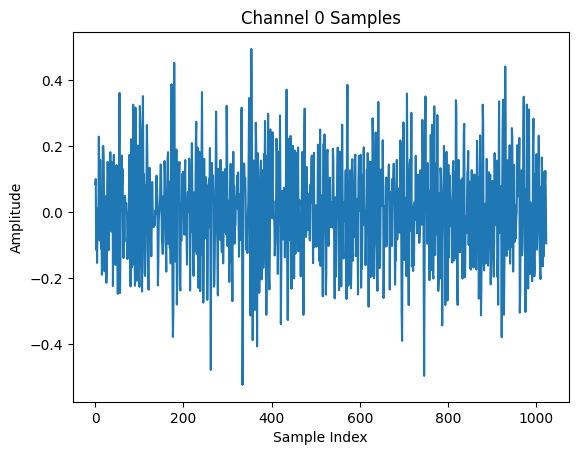

(32768,)


In [3]:
# Load binary data file
# path = "/Users/brunogas/manips/Tests-Modo/Avec_voie_analogique/WhiteNoise-2m.dat"
# path = "/Users/brunogas/Manips/Tests-modo/Avec_voie_analogique/WhiteNoise-2m.dat"
path = "/Users/brunogas/Manips/Tests-modo-2/recording2-1m-73-5db-snm.dat"
# Read binary file as int32 elements
with open(path, "r") as f:
    data = np.fromfile(f, dtype=np.int32)

nbytes = data.shape[0]
# nchannels = 256 + 1 + 1
nchannels = 256 + 1
nsamples = nbytes // nchannels
print("Bytes=", nbytes)
print("Channels=", nchannels)
print("Samples=", nsamples)

# Get 1024 samples starting from sample 0s
sample_start = 5000 * nchannels
sample_end = sample_start + 1024 * nchannels
selected_samples = data[sample_start:sample_end]

# reshape into an array of shape (nsamples, nchannels)
selected_samples_reshaped = selected_samples.reshape((-1, nchannels))
print("selected_samples_reshaped.shape: ", selected_samples_reshaped.shape)

selected_32_mems_samples = selected_samples_reshaped[:, 1:33]
print("selected_32_mems_samples.shape: ", selected_32_mems_samples.shape)

# Convert to float32 using the MEMS sensibility factor
selected_32_mems_samples = selected_32_mems_samples.astype(np.float32) * MU_MEMS_SENSIBILITY

# Plot the channel 0
plt.plot(selected_32_mems_samples[:, 0])
plt.title("Channel 0 Samples")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

# Transform the signal into a 1D vector of values interleaved per MEMS
# (e.g., [mems1_sample1, mems2_sample1, ..., memsN_sample1, mems1_sample2, ...])
# and store it in a json file
# Flatten the signal array in C order (row-major) to achieve interleaving
selected_32_mems_samples_flat = selected_32_mems_samples.flatten(order='C')
print(selected_32_mems_samples_flat.shape)

# Store the signal in a json file
with open("signal_square.json", "w") as f:
    json.dump(selected_32_mems_samples_flat.tolist(), f)

## Create the beamformer

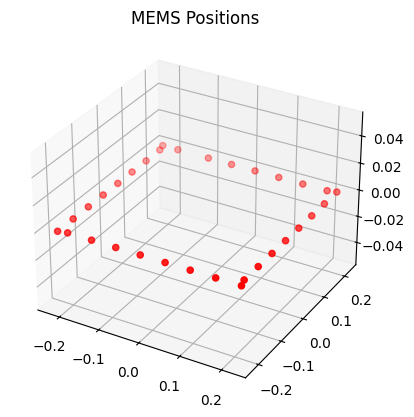

In [4]:
# Load antenna MEMS positions (relative to the center of the antenna)
with open("mems_position_square_relative.json", "r") as f:
    mems_position = np.array( json.load(f) )

# Define antenna focal (focal_depth = 2.0 meters because source is 2 meters away from the antenna)
focal_plan_width = 4.0
focal_plan_depth = 4.0
focal_depth = 1.78
focal_plan_width_sampling = 41
focal_plan_depth_sampling = 41

# Define the locations where the BFE is somputed (2 meters from the source since focal_depth = 2.0)
locations = np.array( horizontalPlan( focal_plan_width, focal_plan_depth, focal_depth, focal_plan_width_sampling, focal_plan_depth_sampling ) )

# Create the beamformer
bmf = BeamformerFDAS( 
    mems_position = mems_position,
    locations = locations,
    sampling_frequency = 50000,
    frame_length = 1024,
)

# Plot the MEMS position
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mems_position.T[0,:], mems_position.T[1,:], mems_position.T[2,:], c='r', marker='o') 
ax.set_title("MEMS Positions")
plt.show()

## Compute BFE

In [5]:
# Compute the beamforming energy``
print("shape of selected_32_mems_samples: ", selected_32_mems_samples.shape)
BFE, _, _ = bmf.compute( selected_32_mems_samples )
image = BFE.reshape( ( focal_plan_depth_sampling, focal_plan_width_sampling ) )

shape of selected_32_mems_samples:  (1024, 32)


## Plot the BFE

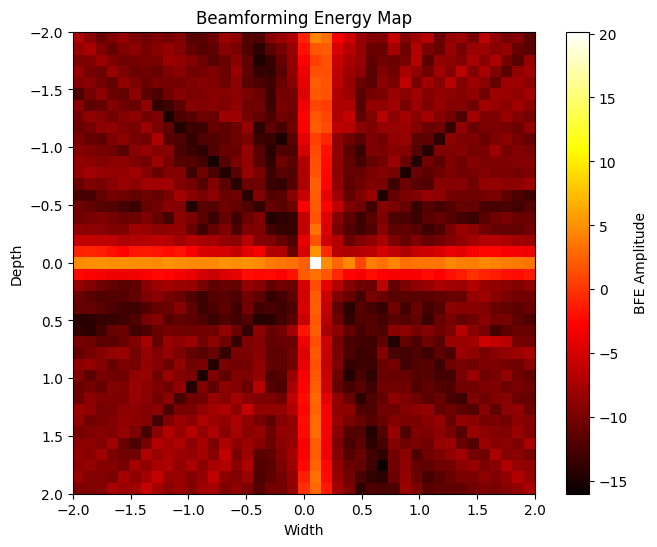

In [6]:
# Calculate the extent of the focal plane in meters
width_extent = [-focal_plan_width/2, focal_plan_width/2]
depth_extent = [-focal_plan_depth/2, focal_plan_depth/2]

# Display the beamforming energy map on the focal plane
plt.figure(figsize=(8, 6))
plt.imshow(
    image, cmap='hot', 
    interpolation='nearest', 
    extent=[width_extent[0], 
        width_extent[1], 
        depth_extent[1], 
        depth_extent[0]
    ]
)
plt.colorbar(label='BFE Amplitude')
plt.title('Beamforming Energy Map')
plt.xlabel('Width')
plt.ylabel('Depth')
plt.show()